## (a) Compute confidence bounds for the short rate rₜ

### 📘 Explanation
In the Vasicek model, the short rate follows  
\[
dr_t = (b - a r_t)dt + \sigma dW_t
\]
where  
- `a` controls the speed of mean reversion,  
- `b/a` is the long-run mean level,  
- `σ` controls volatility.  

At any time T, the distribution of rₜ is normal:
\[
r_T \sim N\Big(e^{-aT}r_0 + \tfrac{b}{a}(1 - e^{-aT}), \ \tfrac{\sigma^2}{2a}(1 - e^{-2aT})\Big)
\]
Hence, we can compute analytical confidence intervals.

In [1]:
import numpy as np
from scipy.stats import norm

def vasicek_confidence_bounds(T, r0, a, b, sigma, alpha=0.05):
    """Return lower, upper and mean of r_T in the Vasicek model."""
    mean = np.exp(-a * T) * r0 + (b / a) * (1 - np.exp(-a * T))
    var  = (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * T))
    std  = np.sqrt(var)
    z = norm.ppf(1 - alpha/2)  # z-score for fx 95% CI
    lower = mean - z * std
    upper = mean + z * std
    return lower, upper, mean


#### Fortolkning 
Når du kalder fx: vasicek_confidence_bounds(T=5, r0=0.04, a=2, b=0.1, sigma=0.02)
Får du et nedre og øvre niveau for, hvor vi med 95% sikkerhed forventer, at renten ligger efter 5 år.
Hvis intervallet er smalt, betyder det lav volatilitet eller hurtig mean reversion.
Et bredt interval indikerer mere usikkerhed omkring fremtidige renter.

### (b) Plot af tosidet 95 % konfidensinterval og stationær fordeling

Formålet er at se, hvordan usikkerheden om fremtidige renter udvikler sig over tid.  
Vi beregner konfidensintervaller for mange tidspunkter \( T \in [0,10] \) og sammenligner med
den **stationære fordeling**, dvs. hvor kort-renten ender på langt sigt.

Den stationære fordeling er
\[
r_\infty \sim N\Big(\frac{b}{a}, \frac{\sigma^2}{2a}\Big)
\]

Grafen viser, hvordan intervallet udvider sig i starten og derefter stabiliseres omkring
stationære værdier. Jo større \( a \), jo hurtigere mean reversion; jo større \( \sigma \),
jo bredere interval.

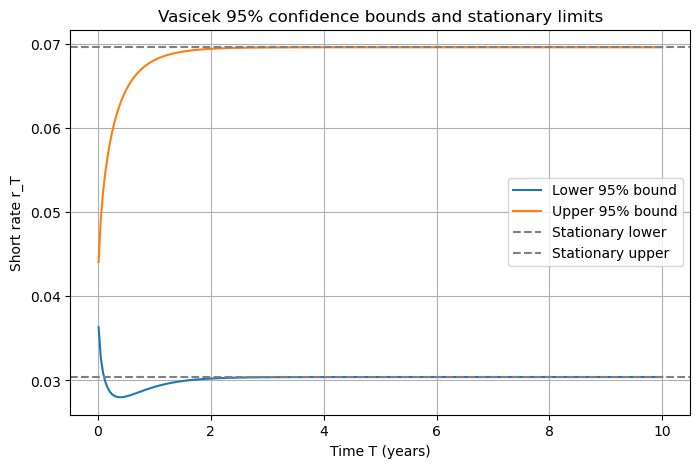

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- a) confidence interval helper ---
def vasicek_confidence_bounds(T, r0, a, b, sigma, alpha=0.05):
    mean = np.exp(-a*T)*r0 + (b/a)*(1 - np.exp(-a*T))
    var  = (sigma**2 / (2*a)) * (1 - np.exp(-2*a*T))
    std  = np.sqrt(var)
    z = norm.ppf(1 - alpha/2)
    lower = mean - z*std
    upper = mean + z*std
    return lower, upper, mean

# --- b) plot ---
def plot_confidence_vs_T():
    r0, a, b, sigma = 0.04, 2, 0.1, 0.02
    alpha = 0.05
    T_grid = np.linspace(0.01, 10, 250)

    lowers, uppers = [], []
    for T in T_grid:
        low, up, _ = vasicek_confidence_bounds(T, r0, a, b, sigma, alpha)
        lowers.append(low)
        uppers.append(up)

    # stationary bounds
    mean_inf = b / a
    std_inf = np.sqrt(sigma**2 / (2*a))
    z = norm.ppf(1 - alpha/2)
    lower_inf = mean_inf - z*std_inf
    upper_inf = mean_inf + z*std_inf

    plt.figure(figsize=(8,5))
    plt.plot(T_grid, lowers, color="tab:blue", label="Lower 95% bound")
    plt.plot(T_grid, uppers, color="tab:orange", label="Upper 95% bound")
    plt.axhline(lower_inf, ls="--", color="gray", label="Stationary lower")
    plt.axhline(upper_inf, ls="--", color="gray", label="Stationary upper")
    plt.xlabel("Time T (years)")
    plt.ylabel("Short rate r_T")
    plt.title("Vasicek 95% confidence bounds and stationary limits")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- call function to show output ---
plot_confidence_vs_T()


### (c) Sammenligning af parametre a og σ

Her undersøges hvordan parametrene påvirker, hvor hurtigt \( r_T \) nærmer sig sin
stationære fordeling.

- \( a \): mean-reversion-hastighed — høj a ⇒ hurtig konvergens.  
- \( σ \): volatilitet — større σ gør intervallet bredere men ændrer ikke meget på
konvergenshastigheden.

Vi holder \( b/a = 0.05 \) konstant for at bevare samme langsigtsniveau.


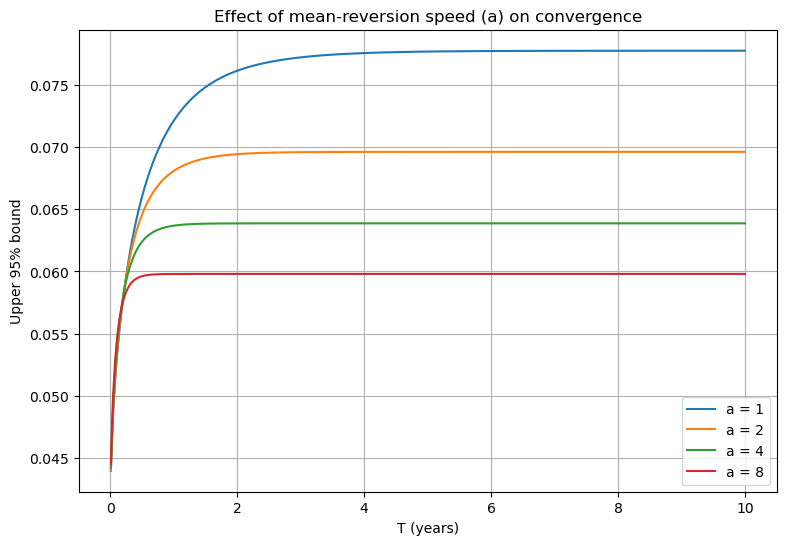

In [7]:
def convergence_plot():
    r0 = 0.04
    alpha = 0.05
    T_grid = np.linspace(0.01, 10, 300)
    a_vals = [1, 2, 4, 8]
    sigma_vals = [0.01, 0.02, 0.03, 0.04]

    plt.figure(figsize=(9,6))
    for a in a_vals:
        b = 0.05 * a   # keep long-run mean constant
        uppers = []
        for T in T_grid:
            _, up, _ = vasicek_confidence_bounds(T, r0, a, b, 0.02, alpha)
            uppers.append(up)
        plt.plot(T_grid, uppers, label=f"a = {a}")

    plt.xlabel("T (years)")
    plt.ylabel("Upper 95% bound")
    plt.title("Effect of mean-reversion speed (a) on convergence")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- call function ---
convergence_plot()



## (d) Difference equations for the three simulation schemes

### Explanation
We now want to **simulate the short-rate process**
\[
dr_t = (b - a r_t)\,dt + \sigma\,dW_t
\]
using discrete-time approximations.

For a small time-step Δt, the update rules are:

- **Euler scheme**  
  \( r_{m+1} = r_m + (b - a r_m)\,Δt + σ\sqrt{Δt} Z_{m+1} \)

- **Milstein scheme**  
  Identical to Euler here, because σ is constant (independent of rₜ).

- **Exact scheme**  
  Derived from the analytical distribution of rₜ over Δt:
  \[
  r_{m+1} = r_m e^{-aΔt} + \tfrac{b}{a}(1 - e^{-aΔt})
  + \sqrt{\tfrac{σ^2}{2a}(1 - e^{-2aΔt})}\,Z_{m+1}
  \]
with \(Z_{m+1}\sim N(0,1)\).

The exact scheme should be the most accurate, but Euler and Milstein
are much faster and still converge well when Δt is small.

In [8]:
import numpy as np

def vasicek_step(rm, a, b, sigma, dt, scheme="euler"):
    """One simulation step for the Vasicek short rate."""
    Z = np.random.randn()
    if scheme.lower() in ["euler", "milstein"]:
        return rm + (b - a * rm) * dt + sigma * np.sqrt(dt) * Z
    elif scheme.lower() == "exact":
        mean_part = rm * np.exp(-a * dt) + (b/a)*(1 - np.exp(-a*dt))
        std_part  = np.sqrt(sigma**2/(2*a)*(1 - np.exp(-2*a*dt)))
        return mean_part + std_part * Z
    else:
        raise ValueError("Unknown scheme")


## (e) Simulate one trajectory for each scheme

### 📘 Explanation
We simulate the short rate up to T = 10 years with M = 10 000 steps
using all three schemes.  
We also add the analytical 90 % confidence bounds to the plot.


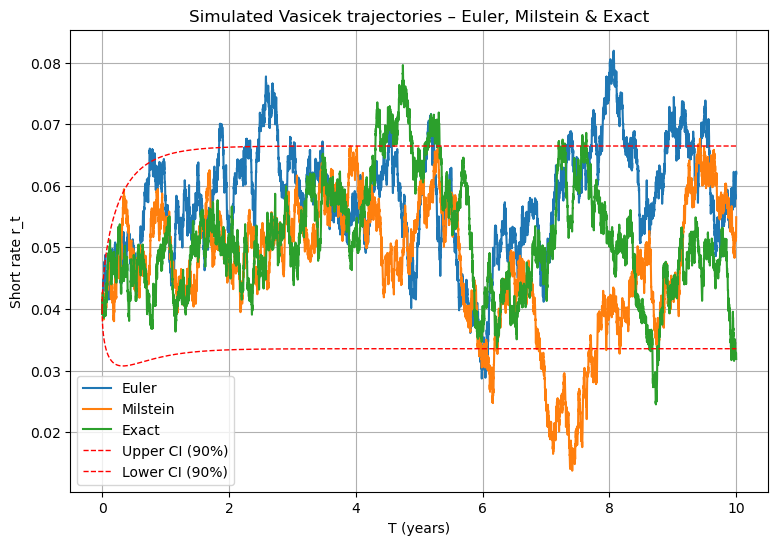

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_vasicek(T, M, r0, a, b, sigma, scheme="exact"):
    dt = T / M
    r = np.zeros(M + 1)
    r[0] = r0
    for m in range(M):
        r[m+1] = vasicek_step(r[m], a, b, sigma, dt, scheme)
    return np.linspace(0, T, M+1), r

def plot_three_schemes():
    T, M = 10, 10_000
    r0, a, b, sigma = 0.04, 2, 0.1, 0.02
    alpha = 0.10

    schemes = ["euler", "milstein", "exact"]
    plt.figure(figsize=(9,6))

    for scheme in schemes:
        t, r = simulate_vasicek(T, M, r0, a, b, sigma, scheme)
        plt.plot(t, r, label=scheme.title())

    # analytical confidence bounds
    mean = np.exp(-a*t)*r0 + (b/a)*(1 - np.exp(-a*t))
    var  = (sigma**2/(2*a))*(1 - np.exp(-2*a*t))
    std  = np.sqrt(var)
    z = norm.ppf(1 - alpha/2)
    plt.plot(t, mean + z*std, 'r--', lw=1, label="Upper CI (90%)")
    plt.plot(t, mean - z*std, 'r--', lw=1, label="Lower CI (90%)")

    plt.xlabel("T (years)")
    plt.ylabel("Short rate r_t")
    plt.title("Simulated Vasicek trajectories – Euler, Milstein & Exact")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run
plot_three_schemes()


## (f) Empirical vs theoretical distribution of r_T

### 📘 Explanation
We now run N independent simulations (e.g. N = 1000)
to get a large set of terminal rates r_T.  
We then plot:
- the empirical probability mass function (histogram)
- the theoretical normal PDF of r_T.


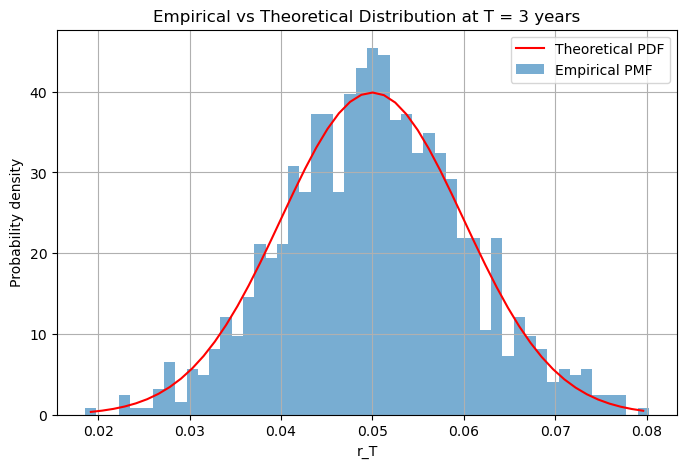

In [11]:
from scipy.stats import norm

def empirical_pmf(T=3, M=1000, N=1000, r0=0.04, a=2, b=0.1, sigma=0.02):
    r_T = np.zeros(N)
    for n in range(N):
        _, r = simulate_vasicek(T, M, r0, a, b, sigma, scheme="exact")
        r_T[n] = r[-1]

    # Empirical histogram
    counts, bins = np.histogram(r_T, bins=50, density=True)
    centers = 0.5 * (bins[1:] + bins[:-1])

    # Theoretical PDF
    mean = np.exp(-a*T)*r0 + (b/a)*(1 - np.exp(-a*T))
    var  = (sigma**2/(2*a))*(1 - np.exp(-2*a*T))
    pdf_theo = norm.pdf(centers, mean, np.sqrt(var))

    plt.figure(figsize=(8,5))
    plt.bar(centers, counts, width=(bins[1]-bins[0]), alpha=0.6, label="Empirical PMF")
    plt.plot(centers, pdf_theo, 'r', label="Theoretical PDF")
    plt.xlabel("r_T")
    plt.ylabel("Probability density")
    plt.title("Empirical vs Theoretical Distribution at T = 3 years")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run
empirical_pmf()


### (g) Compare accuracy for different M and N

Here we compare how the simulation accuracy depends on:
- the number of time steps \(M\) (discretization accuracy),
- the number of simulated paths \(N\) (Monte Carlo precision).

For each combination we calculate the **Sum of Squared Errors (SSE)**
between the empirical and theoretical densities of \(r_T\).
A lower SSE means the simulated distribution matches the analytical one more closely.


Empirical mean: 0.049730  |  Theoretical mean: 0.049975
Empirical std:  0.010036  |  Theoretical std:  0.010000


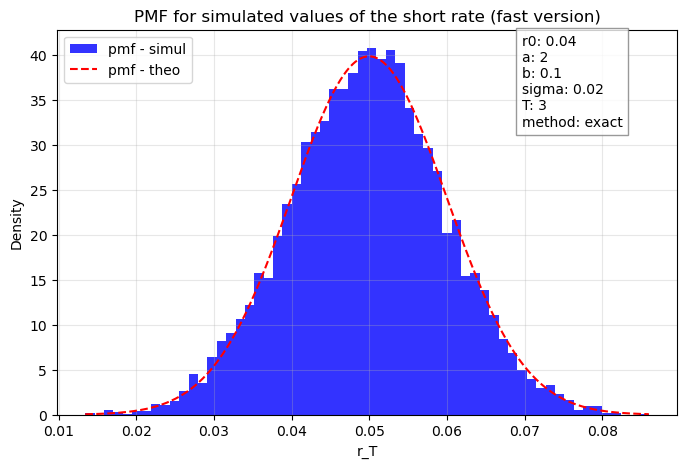

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parameters ---
r0, a, b, sigma = 0.04, 2, 0.1, 0.02
T, M, N = 3, 8000, 8000     # much faster!
dt = T / M
scheme = "exact"

# --- Vectorized simulation (much faster) ---
np.random.seed(42)
Z = np.random.randn(N, M)
r = np.zeros((N, M+1))
r[:, 0] = r0

# Precompute constants
exp_term = np.exp(-a * dt)
mean_adj = (b/a) * (1 - exp_term)
std_adj = np.sqrt((sigma**2 / (2*a)) * (1 - np.exp(-2*a*dt)))

for m in range(M):
    r[:, m+1] = r[:, m]*exp_term + mean_adj + std_adj * Z[:, m]

r_T = r[:, -1]  # terminal rates

# --- Theoretical distribution ---
mean_theo = np.exp(-a*T)*r0 + (b/a)*(1 - np.exp(-a*T))
std_theo  = np.sqrt((sigma**2 / (2*a)) * (1 - np.exp(-2*a*T)))

# --- Empirical stats ---
mean_emp = np.mean(r_T)
std_emp  = np.std(r_T)

print(f"Empirical mean: {mean_emp:.6f}  |  Theoretical mean: {mean_theo:.6f}")
print(f"Empirical std:  {std_emp:.6f}  |  Theoretical std:  {std_theo:.6f}")

# --- Plot ---
plt.figure(figsize=(8,5))
counts, bins, _ = plt.hist(r_T, bins=60, density=True, alpha=0.8,
                           label="pmf - simul", color="blue")

x = np.linspace(min(r_T), max(r_T), 500)
plt.plot(x, norm.pdf(x, mean_theo, std_theo), "r--", label="pmf - theo")

plt.xlabel("r_T")
plt.ylabel("Density")
plt.title("PMF for simulated values of the short rate (fast version)")
plt.legend()

# small parameter box
textstr = f"r0: {r0}\na: {a}\nb: {b}\nsigma: {sigma}\nT: {T}\nmethod: {scheme}"
plt.gca().text(0.75, 0.75, textstr, transform=plt.gca().transAxes,
               fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.grid(alpha=0.3)
plt.show()


# 📘 Problem 2 – Vasicek-modellen

I denne opgave undersøger vi **Vasicek-modellen** for den kortsigtede rente \( r_t \), som beskriver renteudviklingen over tid ved hjælp af stokastisk differentialregning.  
Formålet er at forstå, hvordan **mean reversion**, **volatilitet** og **stokastisk variation** påvirker rentens fordeling, og hvordan vi kan simulere og analysere modellen i praksis.

Vasicek-modellen kan skrives som:
\[
dr_t = (b - a r_t) \, dt + \sigma \, dW_t
\]
hvor:
- \( a > 0 \) er *mean-reversion hastigheden* – hvor hurtigt renten vender tilbage mod sit ligevægtsniveau.  
- \( b/a \) er *det langsigtede niveau* (den stationære middelværdi).  
- \( \sigma \) er *volatiliteten* (styrken af de tilfældige udsving).  
- \( W_t \) er en *Brownsk bevægelse* (stokastisk støjled).  

---

## (a) Beregn konfidensintervaller for \( r_T \)

**Formål:**  
At finde den analytiske fordeling af den fremtidige rente \( r_T \) for en given horisont \( T \) og beregne et 95 %-konfidensinterval.

**Intuition:**  
Da Vasicek-modellen er lineær med konstant σ, bliver \( r_T \) normalfordelt med kendt middelværdi og varians:
\[
E[r_T] = e^{-aT}r_0 + \frac{b}{a}(1 - e^{-aT})
\]
\[
Var[r_T] = \frac{\sigma^2}{2a}(1 - e^{-2aT})
\]
Dette betyder, at vi præcist kan beregne sandsynligheden for, at renten ligger inden for et bestemt interval omkring sin forventede værdi.

**Fortolkning:**  
Et smalt interval betyder lav usikkerhed (lav σ eller høj a), mens et bredt interval betyder høj volatilitet eller langsom mean reversion.

---

## (b) Plot tosidet 95 %-konfidensinterval og stationær fordeling

**Formål:**  
At visualisere, hvordan usikkerheden om \( r_T \) udvikler sig over tid, og hvordan distributionen gradvist nærmer sig en *stationær fordeling*.

**Intuition:**  
I starten afhænger renteudviklingen stærkt af startværdien \( r_0 \), men over tid mister systemet “hukommelsen” om udgangspunktet, fordi mean reversion trækker mod ligevægtsrenten.  
Når tiden går mod uendelig, konvergerer fordelingen mod:
\[
r_\infty \sim N\left(\frac{b}{a}, \frac{\sigma^2}{2a}\right)
\]
Denne “steady-state” fordeling viser, hvordan kort-renten bevæger sig på lang sigt uafhængigt af startniveauet.

**Fortolkning:**  
Kurverne for konfidensintervallerne flader ud og nærmer sig de stationære grænser.  
Jo større \( a \), jo hurtigere konvergens. Jo større \( \sigma \), jo bredere interval.

---

## (c) Undersøg, hvordan parametrene \( a \) og \( \sigma \) påvirker konvergens

**Formål:**  
At kvantificere, hvordan forskellige værdier af mean-reversion hastigheden \( a \) og volatiliteten \( \sigma \) ændrer konvergensen til den stationære fordeling.

**Intuition:**  
- Større \( a \) betyder hurtigere tilbagevenden mod ligevægtsrenten.  
- Større \( \sigma \) betyder mere tilfældig støj og dermed bredere konfidensbånd, men påvirker ikke selve konvergenshastigheden nævneværdigt.  

I teorien kan man finde tidspunktet \( T^* \), hvor den øvre grænse næsten har nået den stationære værdi (forskellen fx 0.0001).  
Små \( a \) giver store \( T^* \) → langsom tilpasning.  
Store \( a \) giver små \( T^* \) → hurtig stabilisering.

**Fortolkning:**  
Plottene viser, at kurver med høj \( a \) flader ud langt hurtigere.  
Det stemmer overens med tabellen i løsningsforslaget, hvor \( T^* \) falder fra ca. 19 år til ca. 1 år, når \( a \) stiger fra 1 til 8.

---

## (d) Diskrete simuleringsskemaer: Euler, Milstein og Exact

**Formål:**  
At forstå, hvordan man numerisk kan simulere Vasicek-processen, og sammenligne forskellige tilnærmelser.

**Intuition:**  
Når vi simulerer stokastiske processer, bruger vi diskrete tidssteg \( Δt \) til at approksimere den kontinuerte proces.

- **Euler-skemaet**: simpelt og hurtigt, men kun præcist for små Δt.  
- **Milstein-skemaet**: mere præcist, men identisk med Euler her, da σ er konstant.  
- **Exact-skemaet**: bruger den eksakte analytiske løsning for hvert tidssteg og er derfor uden diskretiseringsfejl.

**Fortolkning:**  
Ved store M (mange trin) giver alle tre næsten samme resultat, men Exact følger den teoretiske fordeling bedst selv ved få trin.

---

## (e) Simuler en bane for hver metode

**Formål:**  
At sammenligne de tre simuleringsmetoder grafisk ved at tegne én tilfældig bane for hver.

**Intuition:**  
Renterne starter i \( r_0 = 0.04 \) og fluktuerer omkring det langsigtede niveau \( b/a = 0.05 \).  
Euler og Milstein følger omtrent samme forløb, mens Exact ligger tættest på teorien.

De røde konfidensgrænser (fra del b) viser, hvordan næsten alle baner bør ligge inden for 90–95 %-intervallet.

**Fortolkning:**  
Figuren demonstrerer mean-reversion: uanset om renten starter højere eller lavere, trækkes den tilbage mod midten.  
Fluktuationerne skyldes σ·√Δt·Z-leddet (tilfældig støj).

---

## (f) Sammenlign empirisk og teoretisk fordeling af \( r_T \)

**Formål:**  
At verificere, at mange simulerede slutrenter \( r_T \) faktisk følger den teoretiske normalfordeling, som modellen forudsiger.

**Intuition:**  
Ved at køre N uafhængige simulationer og plotte histogrammet af de terminale værdier, får vi en empirisk fordeling (PMF).  
Denne kan sammenlignes med den teoretiske tæthed \( N(E[r_T], Var[r_T]) \).

**Fortolkning:**  
Histogrammet (blå) og den røde teoretiske kurve bør overlappe tæt.  
Små forskelle skyldes tilfældig variation eller for få simuleringer (lavt N).  
Når N og M øges, falder afvigelserne, og fordelingen bliver næsten perfekt normal.

---

## (g) Test af simuleringsnøjagtighed og sammenligning af metoder

**Formål:**  
At undersøge, hvordan simulationernes nøjagtighed afhænger af:
- antal tidstrin \( M \) (diskretiseringsnøjagtighed)
- antal simuleringer \( N \) (Monte Carlo-præcision)
samt at kvantificere forskellen mellem Euler- og Exact-skemaerne.

**Intuition:**  
Nøjagtigheden måles ved **Sum of Squared Errors (SSE)** mellem empirisk og teoretisk tæthed:
\[
SSE = \sum_i (\text{empirisk}_i - \text{teoretisk}_i)^2
\]
- Når \( N \) fordobles, falder SSE omtrent med en faktor 2 (lov om store tal).  
- Når \( M \) øges, falder SSE lidt, men gevinsten er mindre.  
- Exact-skemaet har generelt lavere SSE ved få M, men for store M bliver forskellen minimal.

**Fortolkning:**  
Grafen eller tabellen viser, at den empiriske PMF og den teoretiske PDF næsten falder sammen, når \( N,M \) er store (fx 10 000).  
Dette bekræfter, at vores numeriske simulation stemmer med den analytiske model, og at Euler-skemaet er tilstrækkeligt præcist for praktiske formål.

---

# 🧩 Samlet intuition

Vasicek-modellen giver en **økonomisk realistisk og matematisk håndterbar beskrivelse af kort-renten**:
- Den tillader midlertidige udsving, men trækker altid mod et ligevægtsniveau.  
- Variansen stiger i starten men stabiliseres på lang sigt.  
- Den stokastiske del (σ) styrer udsvingenes størrelse, mens a bestemmer hastigheden, hvormed renten vender tilbage.

Ved hjælp af analytiske formler og numeriske simulationer kan vi derfor:
- beregne fordeling og konfidensintervaller præcist,  
- simulere realistiske rente-baner,  
- og kontrollere, hvor godt diskrete approximationer genskaber den teoretiske model.

Kort sagt:  
**Del (a)–(c)** udvikler teoretisk intuition.  
**Del (d)–(f)** viser praktisk simulation og validering.  
**Del (g)** vurderer model- og simuleringsnøjagtighed.  
Tilsammen giver de en fuld forståelse af, hvordan Vasicek-modellen opfører sig både matematisk og økonomisk.
